In [ ]:
!pip install -U imbalanced-learn
!pip install -U imblearn
#may already be installed on colab

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 257.7/257.7 kB 2.1 MB/s eta 0:00:00
  Attempting uninstall: imbalanced-learn
    Found existing installation: imbalanced-learn 0.10.1
    Uninstalling imbalanced-learn-0.10.1:
      Successfully uninstalled imbalanced-learn-0.10.1


In [ ]:
from google.colab import files
uploaded = files.upload()
#use this to select the CCD.xls file and upload to drive; the following code block will then successfully be able to open it

Saving CCD.xls to CCD.xls


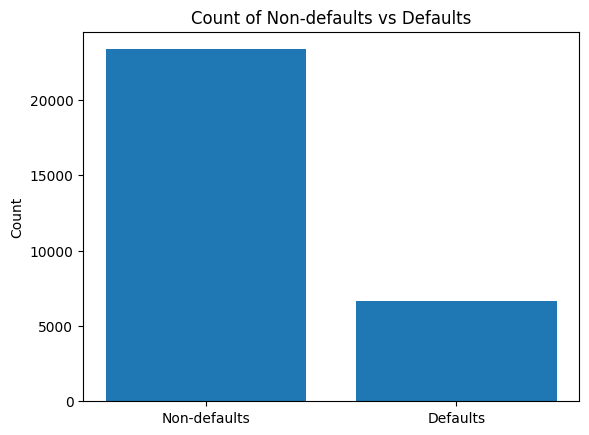

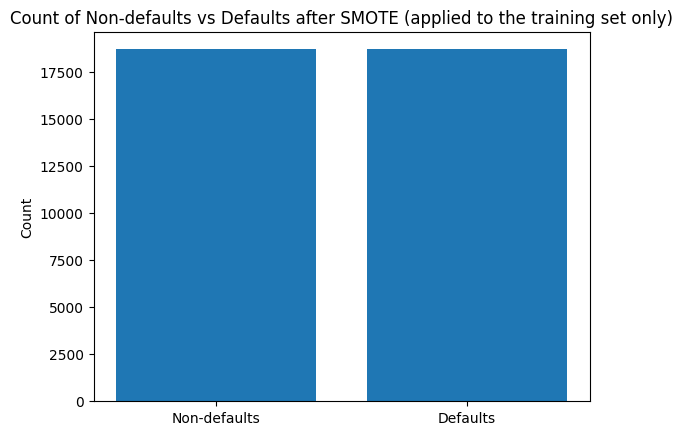

Epoch 1/50
234/234 [==============================] - 7s 10ms/step - loss: 0.3997 - accuracy: 0.6157 - f1: 0.6071 - val_loss: 0.1786 - val_accuracy: 0.6973 - val_f1: 0.8213
Epoch 2/50
234/234 [==============================] - 2s 8ms/step - loss: 0.3502 - accuracy: 0.7221 - f1: 0.6553 - val_loss: 0.1928 - val_accuracy: 0.6758 - val_f1: 0.8062
Epoch 3/50
234/234 [==============================] - 2s 10ms/step - loss: 0.3417 - accuracy: 0.7354 - f1: 0.6619 - val_loss: 0.1257 - val_accuracy: 0.7758 - val_f1: 0.8731
Epoch 4/50
234/234 [==============================] - 2s 9ms/step - loss: 0.3337 - accuracy: 0.7349 - f1: 0.6688 - val_loss: 0.1096 - val_accuracy: 0.8043 - val_f1: 0.8910
Epoch 5/50
234/234 [==============================] - 2s 10ms/step - loss: 0.3312 - accuracy: 0.7379 - f1: 0.6702 - val_loss: 0.1111 - val_accuracy: 0.8029 - val_f1: 0.8902
Epoch 6/50
234/234 [==============================] - 2s 8ms/step - loss: 0.3286 - accuracy: 0.7437 - f1: 0.6736 - val_loss: 0.0985 - val

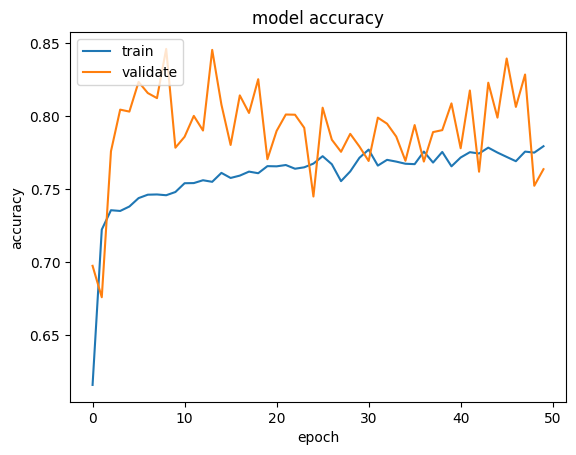

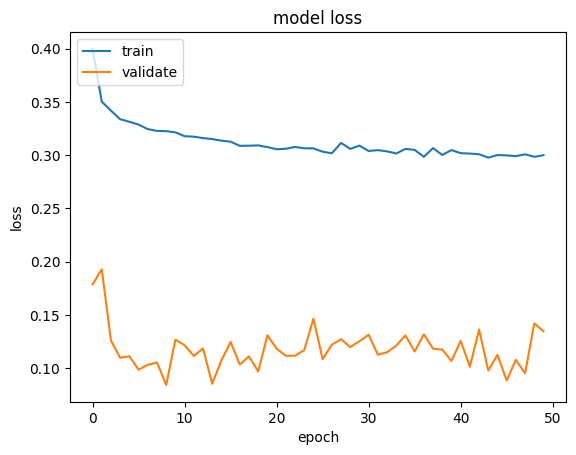

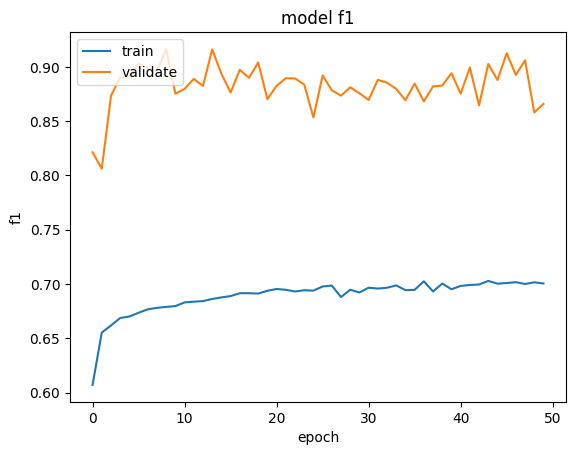

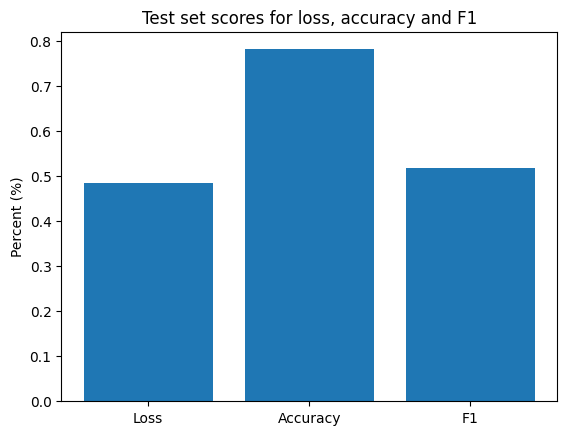

Using the model on the test data again but to calculate exactly how many defaults and non defaults were predicted correctly
188/188 [==============================] - 0s 2ms/step


<ipython-input-3-4372818f4d28>:208: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  defaults_predicted_correctly[int(y_predic[x])] += 1


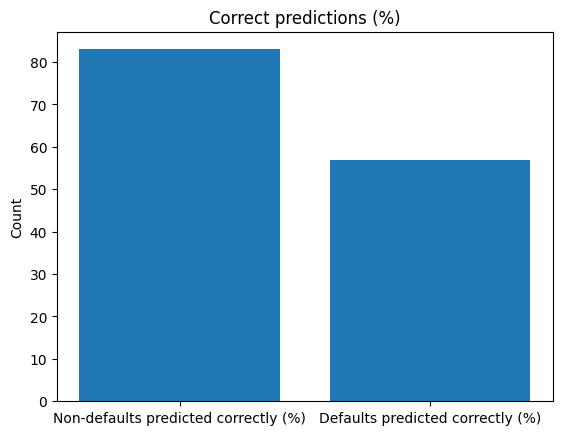

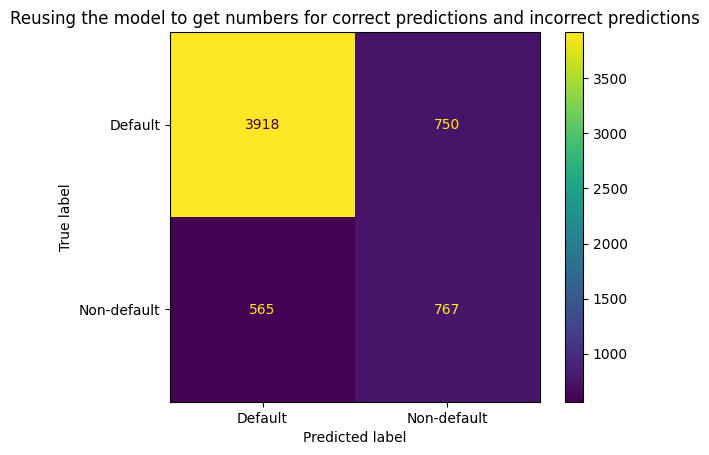

Correctly Predicted defaults:  3918
Incorerctly predicted defaults:  565
Correctly predicted non-defaults:  750
Incorrectly predicted non-defaults:  767


In [ ]:
import pandas as pd
df = pd.read_excel('/content/CCD.xls')  # read the csv file into a pandas dataframe
df.head()
import numpy as np
input = np.delete(df.to_numpy(dtype = None, copy = False), 0, 0) #convert dataframe to numpy array and delete the row of headers
input = input.astype(float) #specify d-type for the array to be a float so that it can be converted to a tensor

from __future__ import print_function #import the required model-building modules
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Normalization
from keras.optimizers import SGD, Adam, RMSprop #import various optimizers to experiment with
import matplotlib.pyplot as plt #used for plotting

#setting parameters
NB_EPOCH = 50
BATCH_SIZE = 128
VERBOSE = 1
OPTIMIZER = Adam(learning_rate=0.001)
VALIDATION_SPLIT = 0.2 #used to determine how to split the data - 80% training, 20% validation


from sklearn.model_selection import train_test_split
#we need to split the data into training sets and testing sets, with the Y variable being the last column of the numpy array
inputs = input[:,:-1] # first 23 columns are features
outputs = input[:,-1] # last column (24th) is the result - (1) if defaulted, (0) if not

#Plot defaults vs non-defaults before SMOTE resampling
defaults_vs_no_defaults = np.array([0,0])
for x in outputs:
  if(x == 0):
    defaults_vs_no_defaults[0] += 1
  else:
    defaults_vs_no_defaults[1] += 1

labels = ['Non-defaults', 'Defaults']
plt.bar(labels, defaults_vs_no_defaults)
plt.ylabel('Count')
plt.title('Count of Non-defaults vs Defaults')
plt.show()





X_train, X_test, y_train, y_test = train_test_split(inputs, outputs, test_size=VALIDATION_SPLIT)
#divides the inputs and outputs into a ratio of 80% training and 20% testing

#import the relevant modules for oversampling
from imblearn.over_sampling import SMOTE
from imblearn.keras import balanced_batch_generator

# we have our data (X_train, y_train) ready so now we instantiate the SMOTE object
smote = SMOTE(random_state=42)
'''
  - random_state determines how random/variable the algorithm is
  - setting it as an integer means in multiple runs, we will get the same result,
      hence making the sampling reproducible so that we can compare other
      hyperparameter tuning later down the line
'''


#resample the training data
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)


#Plot defaults vs non-defaults after SMOTE resampling
defaults_vs_no_defaults = np.array([0,0])
for x in y_train_resampled:
  if(x == 0):
    defaults_vs_no_defaults[0] += 1
  else:
    defaults_vs_no_defaults[1] += 1
labels = ['Non-defaults', 'Defaults']
plt.bar(labels, defaults_vs_no_defaults)
plt.ylabel('Count')
plt.title('Count of Non-defaults vs Defaults after SMOTE (applied to the training set only)')
plt.show()






#building the model - Fully Connected Network (FCN)
model = Sequential()
layer = Normalization() #keras' normalization built into the model's architecture
layer.adapt(X_train)  #set the initial weights of the model to be suited for the global mean and variance calculated
model.add(layer)  #add the normalization layer to the model as the first layer

#now we add the hidden layers


'''the data has been adapted using means and variance to be
within tanh's generalized range of -3 and 3 so the vanishing gradient problem shouldn't be an issue;
due to being a more generalized alternative to sigmoid, tanh is better to use for the first layer of
the model with sigmoid being more appropriate at the end'''
model.add(Dense(64, activation='tanh', input_shape=(X_train.shape[1],)))

model.add(Dense(64, activation='relu', input_shape=(X_train.shape[1],))) #commonly used activation function, mitigates vanishing gradient problem
model.add(Dropout(0.3)) #dropout is to mitigate underfitting -> helps avoid stagnation in the learning

model.add(Dense(64, input_shape=(X_train.shape[1],)))
model.add(Dense(1, activation='sigmoid'))
''' output is 1 or 0 so we use sigmoid, good for binary classification but suffers from vanishing gradient problem
hence why we have used relu in the intermediate hidden layers since relu is very good at mitigating this;
since this is the last layer, we want it to be for a specific range to get the best prediction, hence its usage over tanh'''







import keras.backend as K
import tensorflow as tf

def f1(y_true, y_pred):
    y_pred = K.round(y_pred)
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)          #calculates the sum of true positives
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)  #calculates the sum of true negatives
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)      #calculates the sum of false positives
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)      #calculates the sum of false negatives

    p = tp / (tp + fp + K.epsilon())  #calculates the precision
    r = tp / (tp + fn + K.epsilon())  #calculates the recall

    f1 = 2*p*r / (p+r+K.epsilon())    #calculates the f1 score
    f1 = tf.where(tf.math.is_nan(f1), tf.zeros_like(f1), f1)
    return K.mean(f1)

def f1_loss(y_true, y_pred):
    # these do similar calculations to the f1 function
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.math.is_nan(f1), tf.zeros_like(f1), f1)
    return 1 - K.mean(f1)
    # the theory behind the surrogate loss function is that by minimizing 1 - f(x), we are maximizing f(x) which is an approximation for F1


'''compile model for F1 score and accuracy'''
model.compile(loss=f1_loss,
optimizer=OPTIMIZER,
metrics=['accuracy', f1])

history = model.fit(X_train_resampled, y_train_resampled,
batch_size=BATCH_SIZE, epochs=NB_EPOCH,
verbose=VERBOSE, validation_split=VALIDATION_SPLIT)

score = model.evaluate(X_test, y_test, verbose=VERBOSE)

# summarise history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validate'], loc='upper left')
plt.show()
# summarise history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validate'], loc='upper left')
plt.show()
# summarise history for f1-score
plt.plot(history.history['f1'])
plt.plot(history.history['val_f1'])
plt.title('model f1')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['train', 'validate'], loc='upper left')
plt.show()

#plot test scores as bar chart
labels = ['Loss', 'Accuracy', 'F1']
plt.bar(labels, score)
plt.ylabel('Percent (%)')
plt.title('Test set scores for loss, accuracy and F1')
plt.show()


print("=========================")
print("Using the model on the test data again but to calculate exactly how many defaults and non defaults were predicted correctly")
print("=========================")

''' Plotting the percentages of correct predictions for defaults and non-defaults for the testing '''
total_nondefaults = 0
total_defaults = 0
for x in y_test:
  if x == 0:
    total_nondefaults += 1
  else:
    total_defaults += 1

y_predic = np.round(model.predict(X_test)) #gets all predictions for y values
defaults_predicted_correctly = np.array([0,0]) #first entry corresponds to non-defaults, second entry corresponds to defaults
for x in range(0, len(y_predic)):
  if(y_predic[x] == y_test[x]):
      defaults_predicted_correctly[int(y_predic[x])] += 1

defaults_predicted_correctly[0] /= (total_nondefaults / 100)
defaults_predicted_correctly[1] /= (total_defaults / 100)
#these lines get the correct predictions for each class as percentages


labels = ['Non-defaults predicted correctly (%)', 'Defaults predicted correctly (%)']
plt.bar(labels, defaults_predicted_correctly)
plt.ylabel('Count')
plt.title('Correct predictions (%)')
plt.show()

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test, y_predic)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Default", "Non-default"])
disp.plot()
plt.title("Reusing the model to get numbers for correct predictions and incorrect predictions")
plt.show()

print("Correctly Predicted defaults: ", cm[0][0])
print("Incorerctly predicted defaults: ", cm[1][0])
print("Correctly predicted non-defaults: ", cm[0][1])
print("Incorrectly predicted non-defaults: ", cm[1][1])